Ref: https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py

In [1]:
import torch

#### Autograd

In [2]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

We create another tensor ``Q`` from ``a`` and ``b``: 

\begin{align}Q = 3a^3 - b^2\end{align}

In [3]:
Q = 3*a**3 - b**2

In [4]:
Q

tensor([-12.,  65.], grad_fn=<SubBackward0>)

In [5]:
Q_sum = Q.sum()

In [6]:
Q_sum

tensor(53., grad_fn=<SumBackward0>)

assume ``a`` and ``b`` are the parameters of an NN, and ``Q`` is the error. In NN training, we want gradients of the error
wrt. parameters, i.e.

$$ \frac{\partial Q}{\partial a} = 9a^2 $$

$$ \frac{\partial Q}{\partial b} = -2b $$


call ``.backward()`` on ``Q`` -> autograd calculates these gradients and stores them in the respective tensors' ``.grad`` attribute.

In [7]:
# Q_sum.backward(retain_graph=True)
Q_sum.backward()

In [8]:
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


#### Computational Graph

Let's try backpropagating again

We need to explicitly pass a ``gradient`` argument in ``Q.backward()`` because it is a vector.
``external_gradient`` is a tensor of the same shape as ``Q``, and it represents the
gradient of Q w.r.t. itself.

In [9]:
Q.shape

torch.Size([2])

In [10]:
external_grad = torch.tensor([1., 1.])

In [11]:
Q.backward(gradient=external_grad)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

This does not work - Computation Graphs are dynamic in PyTorch. After ```.backward()``` is called, autograd starts populating a new graph. This allows for control flow statements and makes it very flexible (possible to vary shape and operations at every iteration).

In a forward pass, autograd does two things simultaneously:

- run the requested operation to compute a resulting tensor, and
- maintain the operation’s gradient function in the directed acyclic graph (DAG) .


The backward pass kicks off when .backward() is called on the DAG root. autograd then:

- computes the gradients from each .grad_fn,
- accumulates them in the respective tensor’s .grad attribute, and
- using the chain rule, propagates all the way to the leaf tensors (the input nodes).

The DAG for our example above
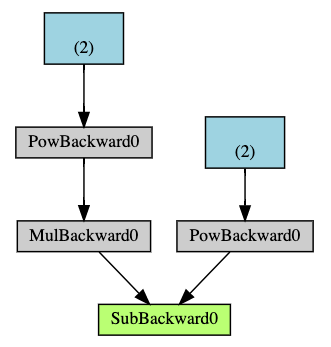

#### Exclusion from the DAG

In [12]:
x = torch.rand(5, 5)
y = torch.rand(5, 5)
z = torch.rand((5, 5), requires_grad=True)

a = x + y
print(f"Does `a` require gradients? : {a.requires_grad}")
b = x + z
print(f"Does `b` require gradients?: {b.requires_grad}")

Does `a` require gradients? : False
Does `b` require gradients?: True


These are called __frozen parameters__ . Freezing parameters is useful for
- performance benefits (reducing autograd computations)
- finetuning a pre-trained network

This functionality is also available with the context manager ```torch.no_grad()```

More useful info on https://pytorch.org/tutorials/